In [1]:
# Importing modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import numba
import pyarrow.dataset as ds
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
import hdbscan
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner

In [2]:
# Pandas display options (personal preference)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [3]:
# Matplotlib options
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.visible'] = 'True'
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.visible'] = 'True'
plt.rcParams['axes.linewidth'] = 1.2

plt.rcParams['figure.figsize'] = [10,8]
font = {'size'   : 20}
plt.rc('font', **font)

In [ ]:
# Importing the G09 parquet file
dataset = ds.dataset("../../data/WD10/WD10_2p4.parquet", format="parquet")
table = dataset.to_table()

# Setting uberID as index
df = table.to_pandas().set_index('uberID')
df.index=df.index.astype('int64')

del dataset,table

In [5]:
# Getting rid of weird spaces in the class column
df=df.replace({'class': {'ambiguous ': 'ambiguous',
                         'star      ': 'star', 
                         'galaxy    ': 'galaxy', 
                         'artefact  ':'artefact'}})

In [6]:
# Making a number of cuts: magnitude, mask, starmask and removing artefacts
df=df[(df['mag_Zt']<22) & 
      (df['mask']==0) & 
      (df['starmask']==0) & 
      (df['class']!='artefact')&
      (df['duplicate']==0)
]

In [7]:
# Getting a 1/10 subset of the data (for the purpose of this tutorial)
# df=df[::10]

In [8]:
# Define the bands and their corresponding flux columns
bands = ['u', 'g', 'r', 'i', 'Z', 'Y', 'J', 'H', 'K']
tot_suffix = 't'
col_suffix = 'c'

# Loop through each band and calculate magnitudes for both 'tot' and 'col'
for band in bands:
    df[f'mag_{band}_tot'] = 8.9 - 2.5 * np.log10(df[f'flux_{band}t'])
    df[f'mag_{band}_col'] = 8.9 - 2.5 * np.log10(df[f'flux_{band}c'])

/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, me

In [9]:
len (df)

97644

In [ ]:
# Remove columns that have very high UMAP1 in the previus runs
df_bad = pd.read_csv('WD10_with_bad_umap1.csv',index_col='uberID')
df = df.drop(df_bad.index)

In [ ]:
len(df)

In [10]:
# Generate lists for 'tot' and 'col' features
mag_tot_features = [f'mag_{band}_tot' for band in bands]
mag_col_features = [f'mag_{band}_col' for band in bands]

# Making a list of all features we will use for UMAP
features = mag_tot_features + mag_col_features + ['R50', 'R90', 'axrat']

# Colours list
colours = mag_col_features

In [11]:
# Removing all rows of the dataframe with NaN values
df_lim=df[features]

df=df.drop(df_lim[df_lim.isnull().any(axis=1)].index)

del df_lim

In [12]:
# Making an empty array ready to put features
X = np.zeros((len(df), 48))

In [13]:
# Filling the first 36 features as each unique colours
l=0
for i in tqdm(range(len(colours))):
    for j in range(i+1,len(colours)):
        X[:,l]=(df[colours[i]] - df[colours[j]])
        l+=1

  0%|          | 0/9 [00:00<?, ?it/s]

In [14]:
# Filling the remaining features (total fluxes and size information)
X[:,36]=(df['mag_u_tot'])
X[:,37]=(df['mag_g_tot'])
X[:,38]=(df['mag_r_tot'])
X[:,39]=(df['mag_i_tot'])
X[:,40]=(df['mag_Z_tot'])
X[:,41]=(df['mag_Y_tot'])
X[:,42]=(df['mag_J_tot'])
X[:,43]=(df['mag_H_tot'])
X[:,44]=(df['mag_K_tot'])
X[:,45]=np.log10(df['R50'])
X[:,46]=df['R50']/df['R90']
X[:,47]=df['axrat']

In [15]:
# Scaling features to 0 mean and unit variance
X = StandardScaler().fit_transform(X)

In [16]:
# Applying UMAP to our features
# These parameters have been fairly tuned, but there's definitely some room for some more tinkering
# This takes about 5 minutes on my PC
X_umap=umap.UMAP(
    n_neighbors=200,
    min_dist=0,
    n_components=10,
    random_state=42,
    # tqdm_kwds={}
).fit_transform(X)
print('Done')

/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Done


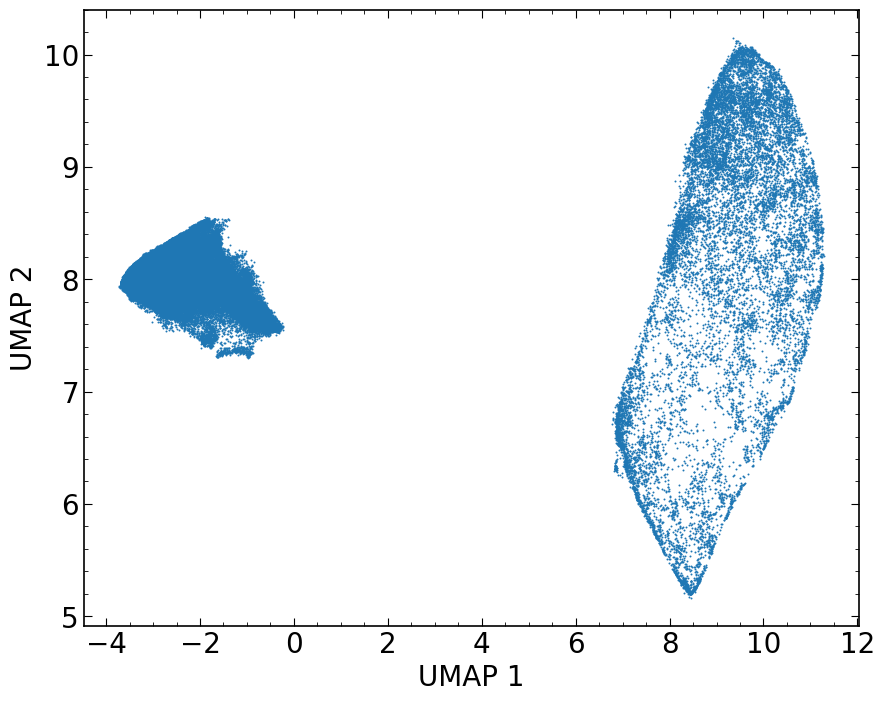

In [17]:
# Plotting the first two UMAP features
plt.scatter(X_umap[:,0],X_umap[:,1],s=2,linewidth=0)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [18]:
# Loop through UMAP components and assign them to the DataFrame
for i in range(10):
    df[f'umap{i+1}'] = X_umap[:, i]

In [19]:
# Defining labels as stars, galaxies, ambiguous
labels=np.unique(df['class'])
colors=['black','red','blue']

  0%|          | 0/3 [00:00<?, ?it/s]

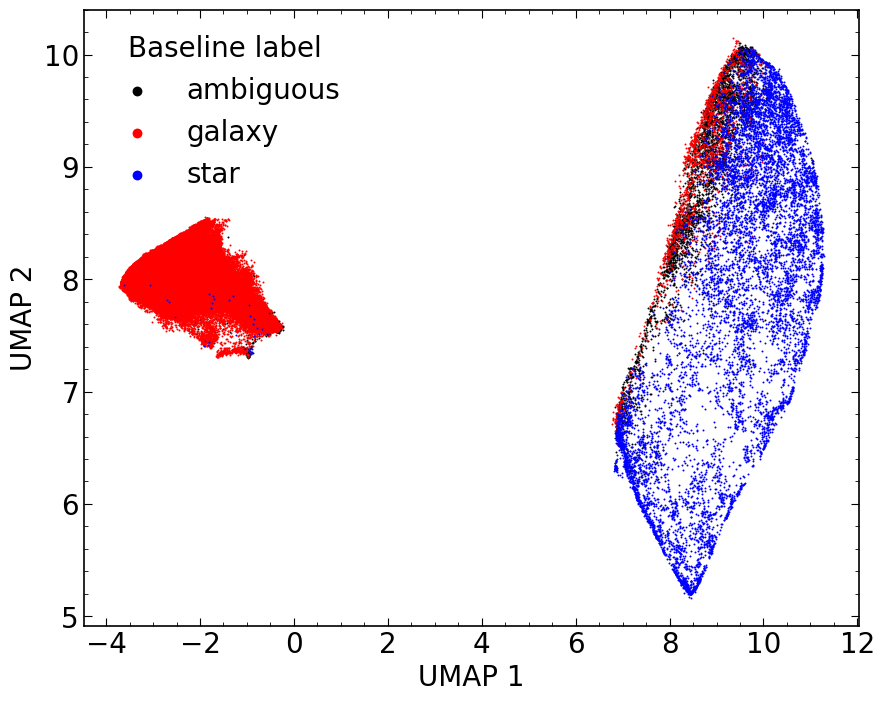

In [ ]:
# Plotting UMAP 1 and UMAP 2 with baseline label as colour
for i in tqdm(range(len(labels))):
    plt.scatter(df[df['class']==labels[i]]['umap1'],
                df[df['class']==labels[i]]['umap2'],
                s=2,label=labels[i],c=colors[i],linewidth=0)

lgnd=plt.legend(frameon=False,title='Baseline label')

lgnd.legend_handles[0]._sizes = [50]
lgnd.legend_handles[1]._sizes = [50]
lgnd.legend_handles[2]._sizes = [50]
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.savefig('../plots/WD10/UMAP_u_baseline_WD10.jpg',bbox_inches='tight',dpi=100,facecolor='white')

plt.show()

In [21]:
# HDBSCAN clustering the UMAP feautre space
# min_samples should be probably 1000 when you apply to the entirety of the sample
clusterer = hdbscan.HDBSCAN(core_dist_n_jobs=-1,min_samples=100).fit(X_umap)

/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [22]:
# Setting the output of HDBSCAN into the dataframe
df['cluster_label']=clusterer.labels_

In [23]:
# Defining the unique cluster labels
clusterer_labels=np.unique(df['cluster_label'])

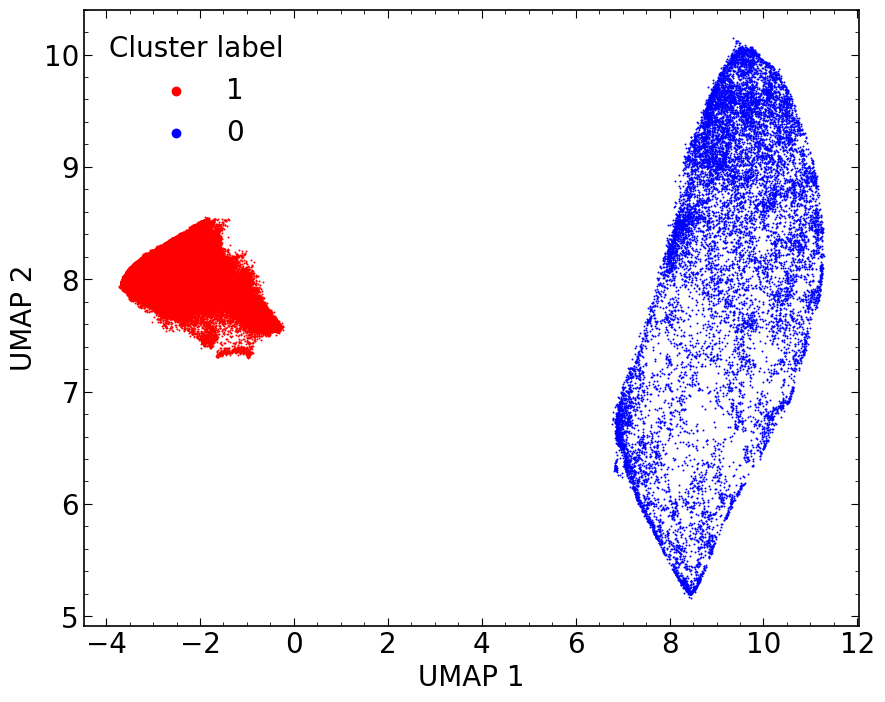

In [ ]:
# Plotting UMAP 1 and UMAP 2 again with cluster label. Should correspond roughly with previous plot
plt.scatter(df[df['cluster_label']==1]['umap1'],
            df[df['cluster_label']==1]['umap2'],
            s=2,linewidth=0,label='1',c='red')

plt.scatter(df[df['cluster_label']==0]['umap1'],
            df[df['cluster_label']==0]['umap2'],
            s=2,linewidth=0,label='0',c='blue')

# plt.scatter(df[df['cluster_label']=='galaxy']['umap1'],
#             df[df['cluster_label']=='galaxy']['umap2'],
#             s=2,linewidth=0,label='galaxy',c='red')

# plt.scatter(df[df['cluster_label']=='star']['umap1'],
#             df[df['cluster_label']=='star']['umap2'],
            # s=2,linewidth=0,label='star',c='blue')
lgnd=plt.legend(frameon=False,title='Cluster label')

lgnd.legend_handles[0]._sizes = [50]
lgnd.legend_handles[1]._sizes = [50]
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.savefig('../plots/WD10/UMAP_u_cluster_WD10_u.jpg',bbox_inches='tight',dpi=100,facecolor='white')

plt.show()

In [33]:
# For each HDBSCAN label, see how the baseline classification corresponds
for label in clusterer_labels:
    print(label,':')
    print('galaxy:',len(df[(df['cluster_label']==label) & (df['class']=='galaxy')]))
    print('star:',len(df[(df['cluster_label']==label) & (df['class']=='star')]))
    print('ambiguous:',len(df[(df['cluster_label']==label) & (df['class']=='ambiguous')]))

0 :
galaxy: 0
star: 0
ambiguous: 0
1 :
galaxy: 0
star: 0
ambiguous: 0


In [27]:
# Manually defining the HDBSCAN outputs to galaxy or star, based on the previous cell
df['cluster_label']=df['cluster_label'].replace([1], 'galaxy')
df['cluster_label']=df['cluster_label'].replace([0], 'star')

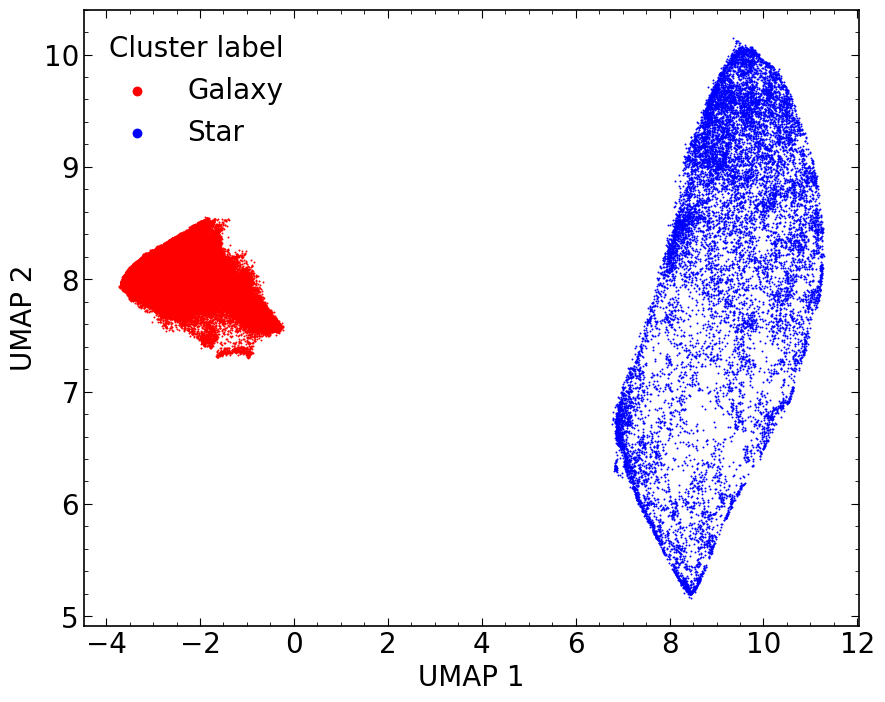

In [ ]:
# Plotting UMAP 1 and UMAP 2 again with cluster label. Should correspond roughly with previous plot
plt.scatter(df[df['cluster_label']=='galaxy']['umap1'],
            df[df['cluster_label']=='galaxy']['umap2'],
            s=2,linewidth=0,label='Galaxy',c='red')

plt.scatter(df[df['cluster_label']=='star']['umap1'],
            df[df['cluster_label']=='star']['umap2'],
            s=2,linewidth=0,label='Star',c='blue')

lgnd=plt.legend(frameon=False,title='Cluster label')

lgnd.legend_handles[0]._sizes = [50]
lgnd.legend_handles[1]._sizes = [50]
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.savefig('../plots/WD10/UMAP_u_cluster_WD10_u.jpg',bbox_inches='tight',dpi=100,facecolor='white')

plt.show()

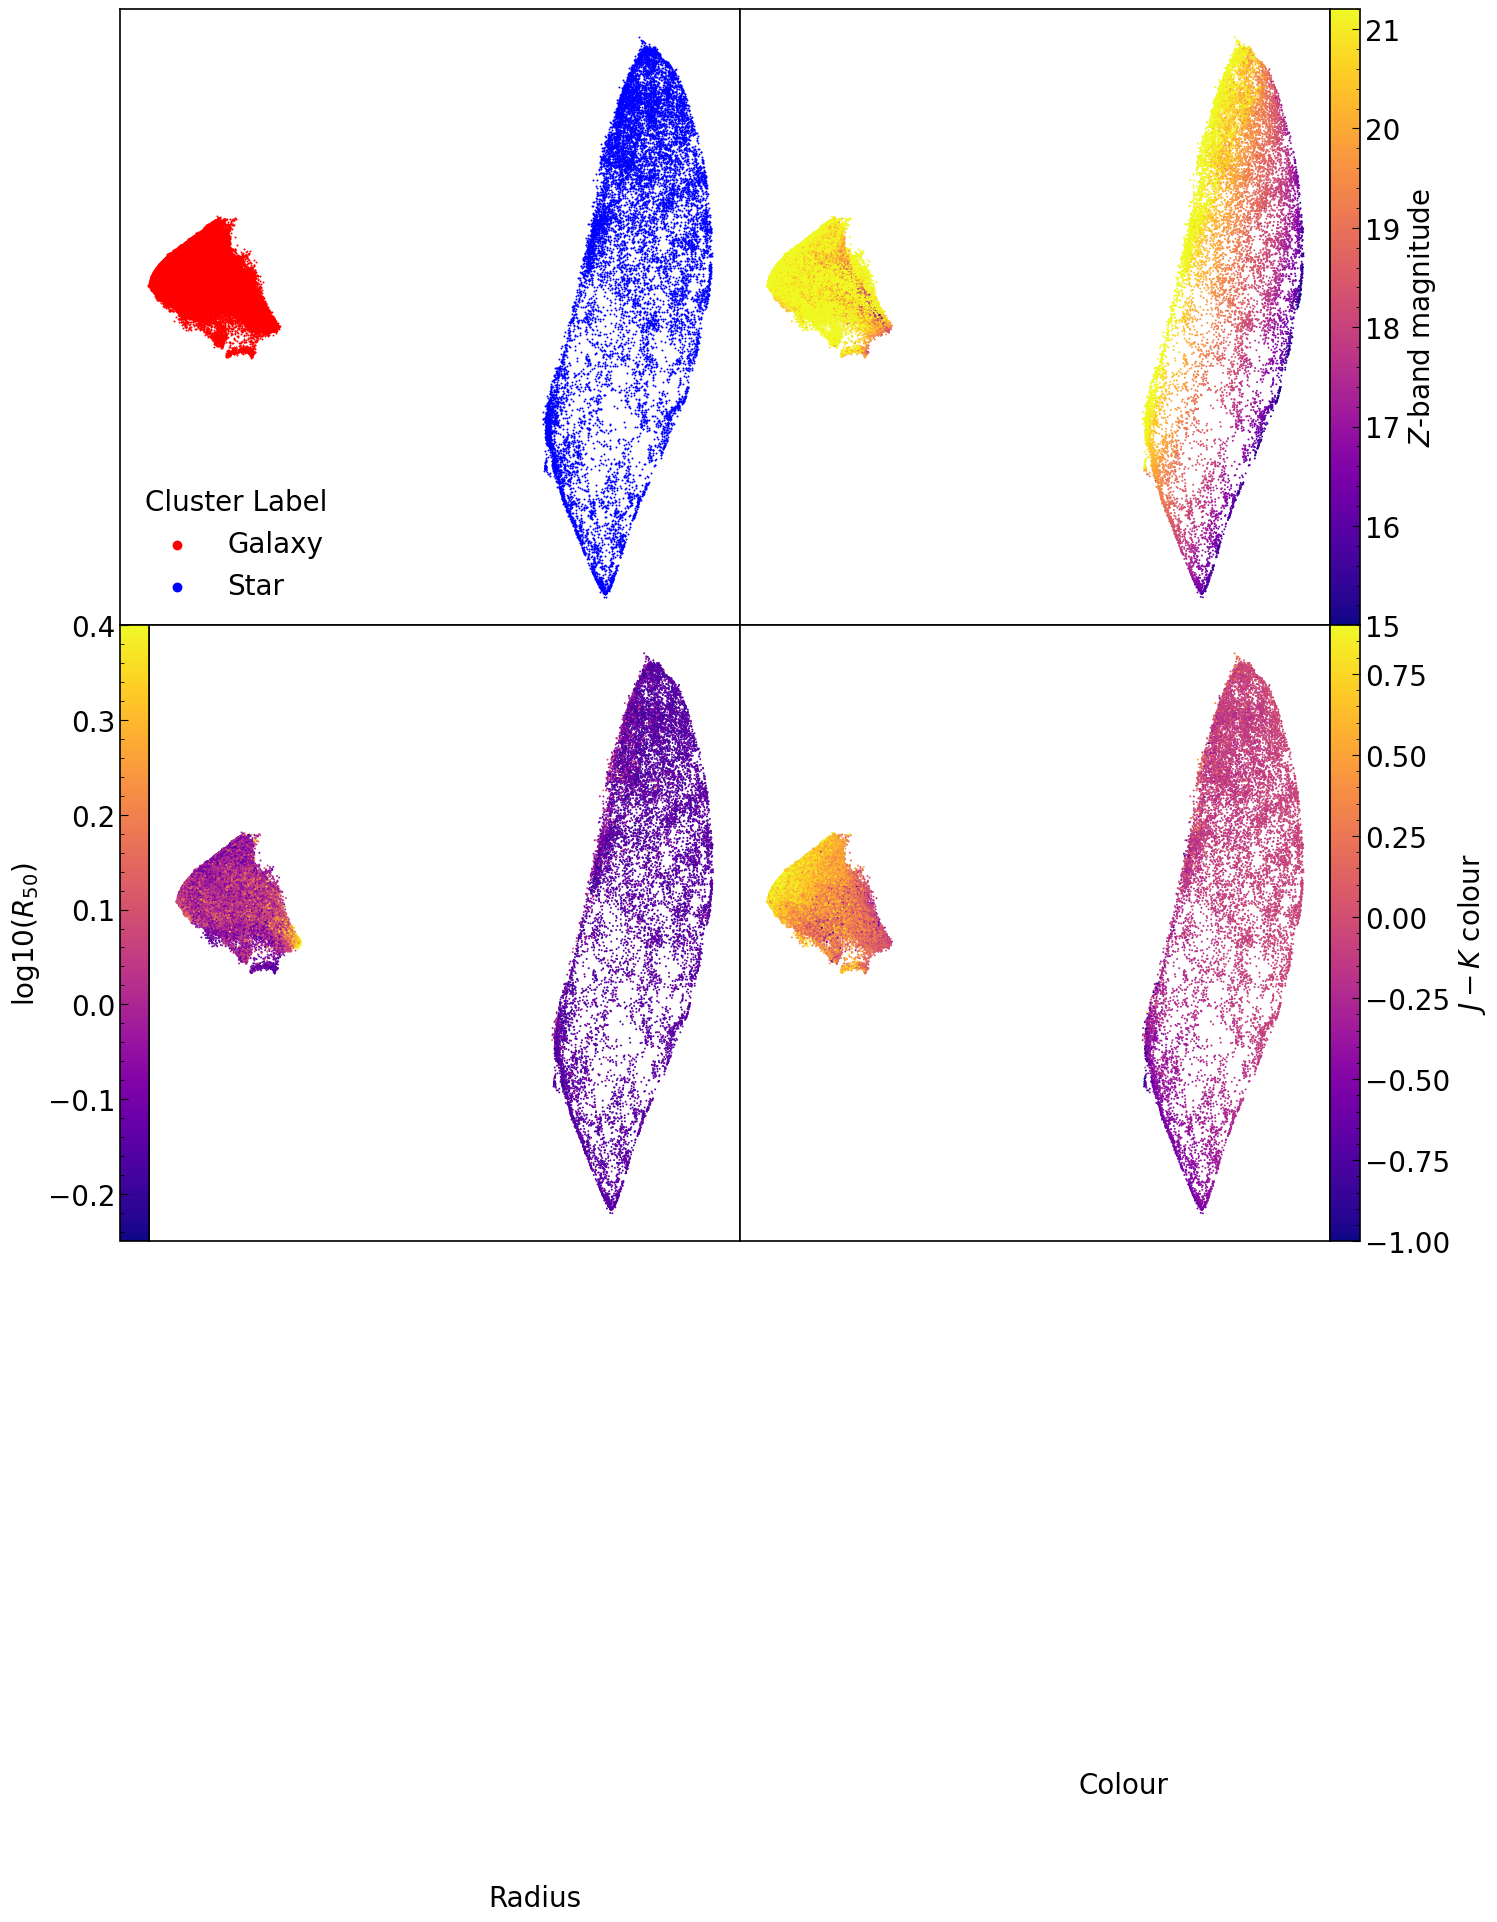

In [ ]:
#Plotting UMAP 1 and 2 as function of different feautres

fig = plt.figure(figsize=(16,16))
spec = matplotlib.gridspec.GridSpec(ncols=2, nrows=2) # 6 columns evenly divides both 2 & 3
plt.subplots_adjust(wspace=0.0,hspace=0)
ax1 = fig.add_subplot(spec[0,0]) 
ax2 = fig.add_subplot(spec[0,1])
ax3 = fig.add_subplot(spec[1,0])
ax4 = fig.add_subplot(spec[1,1]) 

cluster_labels=['galaxy','star']
cluster_colours=['red','blue']
cluster_labels2=['Galaxy','Star']


for i in range(len(cluster_labels)):
    ax1.scatter(df[df['cluster_label']==cluster_labels[i]]['umap1'][::1],
               df[df['cluster_label']==cluster_labels[i]]['umap2'][::1],
               linewidth=0,s=2,c=cluster_colours[i],label=cluster_labels2[i])
lgnd=ax1.legend(loc='lower left',frameon=False,title='Cluster Label')
lgnd.legend_handles[0]._sizes = [50]
lgnd.legend_handles[1]._sizes = [50]
ax1.set_xticks([])
ax1.set_yticks([])

im2=ax2.scatter(df['umap1'][::1],df['umap2'][::1],linewidth=0,s=2,c=df['mag_Z_tot'][::1],cmap='plasma')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0)
fig.colorbar(im2, cax=cax, orientation='vertical',label='$Z$'+'-band magnitude')
im2.set_clim(15,21.2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.text(5,0,'Brightness')

im3=ax3.scatter(df['umap1'][::1],df['umap2'][::1],linewidth=0,s=2,c=np.log10(df['R50'][::1]),cmap='plasma')
im3.set_clim(-0.25,0.4)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('left', size='5%', pad=0)
fig.colorbar(im3, cax=cax, orientation='vertical',label='log10('+'$R_{50}$)')
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.text(5,-1,'Radius')

im4=ax4.scatter(df['umap1'][::1],df['umap2'][::1],linewidth=0,s=2,c=df['mag_J_tot'][::1]-df['mag_K_tot'][::1],cmap='plasma')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0)
fig.colorbar(im4, cax=cax, orientation='vertical',label='$J-K$'+' colour')
im4.set_clim(-1,0.9)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.text(5,0,'Colour')

plt.savefig('../plots/UMAP_features_WD10.jpg',bbox_inches='tight',dpi=100)

plt.show()

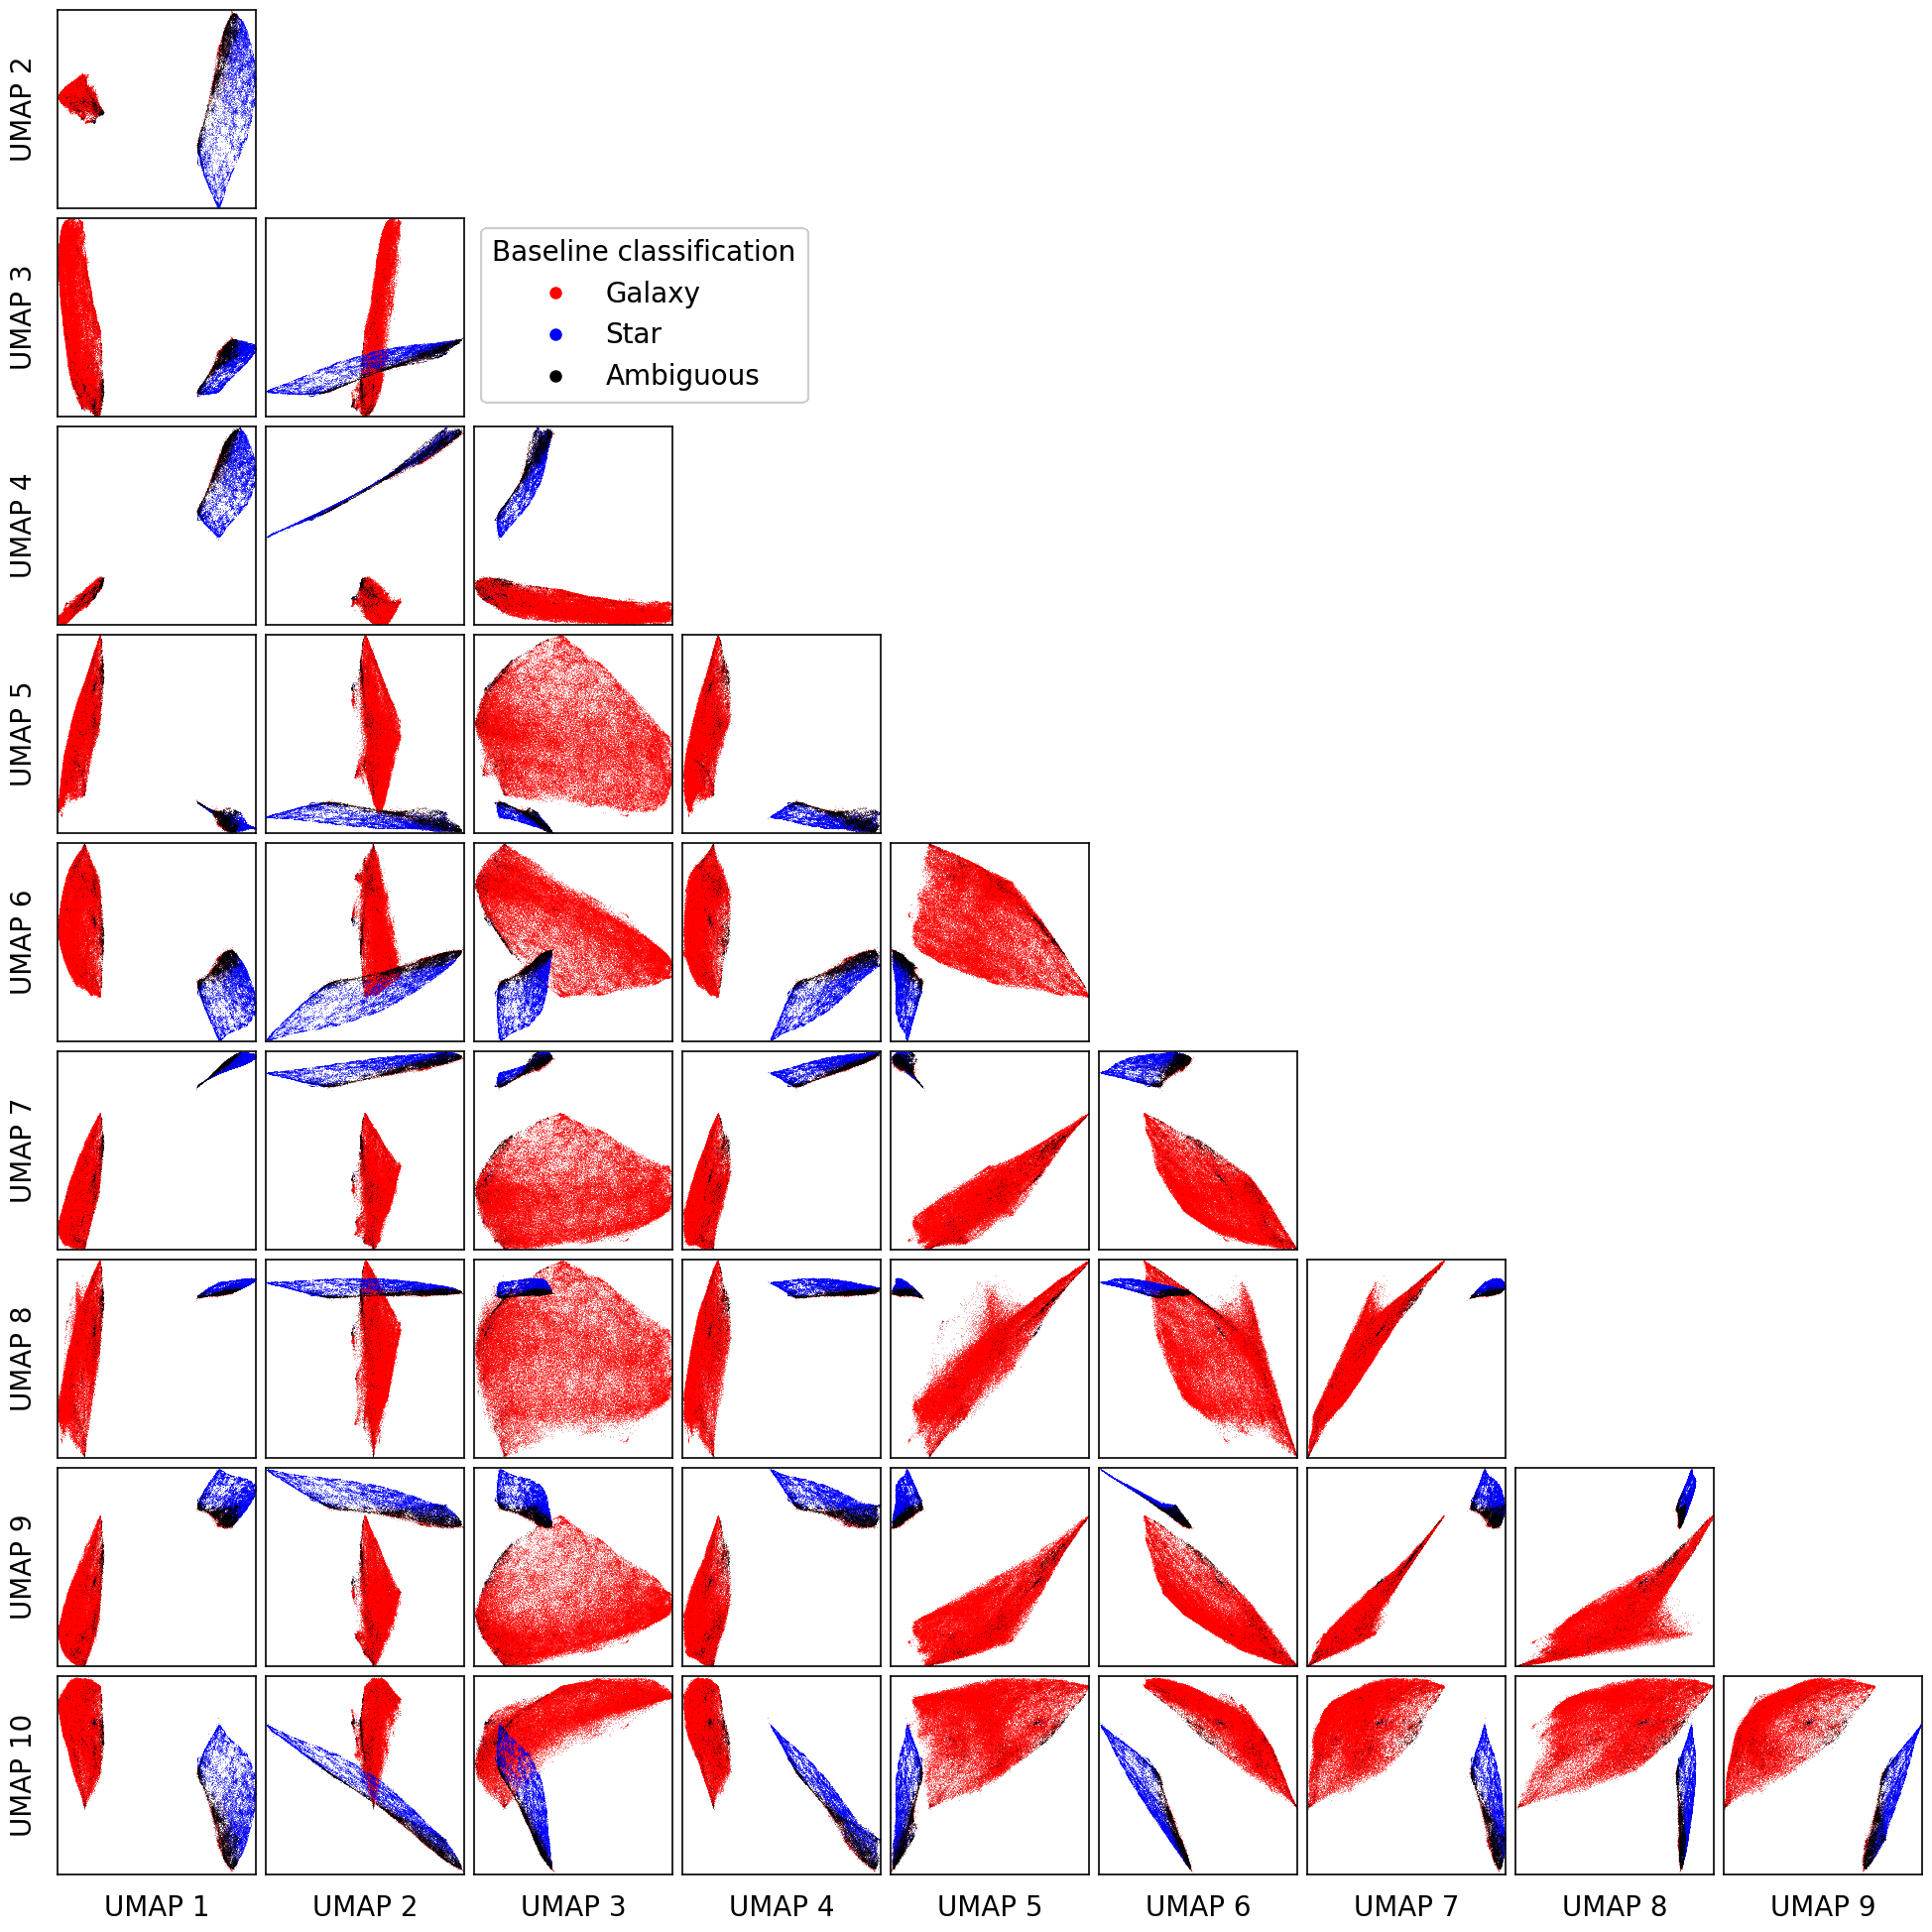

In [ ]:
#Corner plot of all 10 UMAP features

UMAPs = [f'UMAP {i}' for i in range(1, 11)]
umaps = [f'umap{i}' for i in range(1, 11)]

X_galaxy=np.array(df[df['class']=='galaxy'][umaps])
X_star=np.array(df[df['class']=='star'][umaps])
X_ambiguous=np.array(df[df['class']=='ambiguous'][umaps])

data_kwargs={}
data_kwargs['alpha']=1
data_kwargs['markeredgewidth']=0
data_kwargs['ms']=0.5
data_kwargs['color']='red'

data2_kwargs={}
data2_kwargs['alpha']=1
data2_kwargs['markeredgewidth']=0
data2_kwargs['ms']=0.5
data2_kwargs['color']='blue'

data3_kwargs={}
data3_kwargs['alpha']=1
data3_kwargs['markeredgewidth']=0
data3_kwargs['ms']=0.5
data3_kwargs['color']='k'

font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams.update({
    'xtick.bottom': False,   
    'xtick.top': False,      
    'ytick.left': False,     
    'ytick.right': False,    
    'xtick.labelbottom': False, 
    'ytick.labelleft': False,   
})

fig = corner.corner(X_galaxy,plot_datapoints=True,plot_density=False,
                    plot_contours=False,labels=UMAPs,data_kwargs=data_kwargs,
                   labelpad=-0.2)
corner.corner(X_star,plot_datapoints=True,plot_density=False,
                    plot_contours=False,labels=UMAPs,data_kwargs=data2_kwargs,fig=fig,
             labelpad=-0.2)
corner.corner(X_ambiguous,plot_datapoints=True,plot_density=False,
                    plot_contours=False,labels=UMAPs,data_kwargs=data3_kwargs,fig=fig,
             labelpad=-0.2)
ndim=10

axes = np.array(fig.axes).reshape((ndim, ndim))
for a in axes[np.triu_indices(ndim)]:
    a.remove()

    # Adding legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Galaxy'),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Star'),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Ambiguous')]

    fig.legend(handles=handles, loc='center', bbox_to_anchor=(0.31, 0.75), title='Baseline classification')
plt.savefig('../plots/UMAP_corner_WD10_u.jpg',bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
#Saving labels
df.to_csv('../../data/WD10/WD10_u.csv')

In [32]:
df

,FrameName,FrameID,segID,xmax,ymax,censep,RAcen,Deccen,RAmax,Decmax,RAGAIA_r,RAGAIA,DecGAIA,DecGAIA_r,RAGAIA_r_cen,DecGAIA_r_cen,RAcen_gt,Deccen_gt,RAmax_gt,Decmax_gt,RAcen_rt,Deccen_rt,RAmax_rt,Decmax_rt,RAcen_Zt,Deccen_Zt,RAmax_Zt,Decmax_Zt,sky_mean,skyRMS_mean,log10seeing,log10seeing_r,log10seeing_i,log10seeing_Z,log10seeing_Y,mag,EBV,R50,R50_gt,R50_rt,R50_Yt,R50_Jt,R50_Ht,R90,R100,N100,axrat,ang,groupID,Ngroup,mag_app_Zt,mag_Zt,mag_app_gt,mag_app_rt,mag_app_it,mag_app_Yt,flux_ut,flux_err_ut,flux_ut_uncorrected,flux_err_ut_uncorrected,flux_gt,flux_err_gt,flux_gt_uncorrected,flux_err_gt_uncorrected,flux_rt,flux_err_rt,flux_rt_uncorrected,flux_err_rt_uncorrected,flux_it,flux_err_it,flux_it_uncorrected,flux_err_it_uncorrected,flux_Zt,flux_err_Zt,flux_Zt_uncorrected,flux_err_Zt_uncorrected,flux_Yt,flux_err_Yt,flux_Yt_uncorrected,flux_err_Yt_uncorrected,flux_Jt,flux_err_Jt,flux_Jt_uncorrected,flux_err_Jt_uncorrected,flux_Ht,flux_err_Ht,flux_Ht_uncorrected,flux_err_Ht_uncorrected,flux_Kt,flux_err_Kt,flux_Kt_uncorrected,flux_err_Kt_uncorrected,flux_W1t,flux_err_W1t,flux_W1t_uncorrected,flux_err_W1t_uncorrected,flux_W2t,flux_err_W2t,flux_W2t_uncorrected,flux_err_W2t_uncorrected,flux_uc,flux_err_uc,flux_gc,flux_err_gc,flux_rc,flux_err_rc,flux_ic,flux_err_ic,flux_Zc,flux_err_Zc,flux_Yc,flux_err_Yc,flux_Jc,flux_err_Jc,flux_Hc,flux_err_Hc,flux_Kc,flux_err_Kc,flux_W1c,flux_err_W1c,flux_W2c,flux_err_W2c,mask,starmask,starscol,starssize,class,noOPT_r,noOPT_i,noIR_Z,noIR_Y,duplicate,mag_Zc,mag_Zt_fake,mag_u_tot,mag_u_col,mag_g_tot,mag_g_col,mag_r_tot,mag_r_col,mag_i_tot,mag_i_col,mag_Z_tot,mag_Z_col,mag_Y_tot,mag_Y_col,mag_J_tot,mag_J_col,mag_H_tot,mag_H_col,mag_K_tot,mag_K_col,umap1,umap2,umap3,umap4,umap5,umap6,umap7,umap8,umap9,umap10,cluster_label
uberID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
53741013700771,waves_postprocessed_53.9_-26.6.rds,5374.0,458,10136.5,770.5,6705.157716,53.606390,-27.118851,53.606355,-27.118805,53.606483,53.606390,-27.118792,-27.118875,53.606473,-27.118865,53.606413,-27.118868,53.606448,-27.118889,53.606438,-27.118879,53.606448,-27.118889,53.606391,-27.118851,53.606355,-27.118805,0.006383,0.025301,-0.072686,0.643380,0.642938,-0.072271,-0.086977,16.063300,0.014180,0.836855,0.766050,0.745892,0.857463,0.680968,0.622480,2.260227,6.599540,1445,0.950459,21.008265,458,1,16.933797,16.012305,17.330255,16.841586,16.677668,16.948896,2.821301e-04,2.563763e-07,2.649473e-04,2.407621e-07,0.000885,1.524212e-07,0.000844,1.452980e-07,0.001265,4.687419e-07,0.001222,4.527694e-07,0.001394,4.071650e-07,0.001357,3.962806e-07,0.001429,1.159134e-06,0.001400,1.135873e-06,0.001441,2.266972e-06,0.001418,2.231345e-06,0.001245,1.480766e-06,0.001231,1.463917e-06,0.001136,4.675483e-06,0.001128,4.641061e-06,0.000787,3.212514e-06,0.000784,3.197075e-06,0.000342,1.911904e-06,0.000341,1.906886e-06,0.000181,1.502790e-06,0.000181,1.500050e-06,2.792261e-04,1.911977e-07,0.000877,1.102875e-07,0.001253,2.620950e-07,0.001381,2.948605e-07,0.001429,1.159134e-06,0.001441,2.266972e-06,0.001236,8.145253e-07,0.001136,4.675483e-06,0.000780,1.754387e-06,0.000289,4.053011e-07,1.435894e-04,4.360427e-07,0.0,0.0,3.0,3.0,star,0.0,0.0,0.0,0.0,0.0,16.012305,0,17.773877,17.785110,16.532412,16.542571,16.144830,16.155539,16.039333,16.049304,16.012305,16.012305,16.003716,16.003716,16.162178,16.169638,16.261674,16.261674,16.659515,16.670283,8.461037,5.215351,-0.208818,6.758351,1.406018,4.857153,6.534786,5.635551,5.968680,6.161341,star
53740752801525,waves_postprocessed_53.9_-26.6.rds,5374.0,472,7527.5,1524.5,4856.520256,53.850608,-27.056279,53.850641,-27.056273,53.850676,53.850676,-27.056260,-27.056260,53.850653,-27.056261,53.850614,-27.056299,53.850641,-27.056273,53.850618,-27.056275,53.850641,-27.056273,53.850608,-27.056279,53.850641,-27.056273,-0.001477,0.024759,-0.072686,0.643380,0.642938,-0.072271,-0.086977,16.059592,0.015323,0.923591,0.775714,0.7